# Data

## 1.1 Data Processing

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Read the original dataset
df = pd.read_csv('hotel_bookings.csv')

# 1. Drop irrelevant columns
irrelevant_columns = [
    'reservation_status', 'reservation_status_date', 'agent', 'company', 'reservation_id'
]
for col in irrelevant_columns:
    if col in df.columns:
        df = df.drop(columns=col)

# 2. Remove all rows with any missing values
df = df.dropna()

# 3. Cap outliers at the 99th percentile for selected columns
for col in ['lead_time', 'booking_changes']:
    if col in df.columns:
        upper = df[col].quantile(0.99)
        df[col] = np.where(df[col] > upper, upper, df[col])

# 4. Select relevant variables
selected_columns = [
    'is_canceled',
    'lead_time',
    'distribution_channel',
    'deposit_type',
    'market_segment',
    'stays_in_weekend_nights',
    'stays_in_week_nights',
    'country',
    'is_repeated_guest',
    'reserved_room_type',
    'assigned_room_type',
    'booking_changes',
    'adults',
    'children',
    'babies',
    'meal',
    'total_of_special_requests',
    'required_car_parking_spaces'
]
df = df[[col for col in selected_columns if col in df.columns]]

# 5. One-hot encode categorical variables
categorical_cols = [
    'distribution_channel', 'deposit_type', 'market_segment', 'country',
    'reserved_room_type', 'assigned_room_type', 'meal'
]
df = pd.get_dummies(df, columns=[col for col in categorical_cols if col in df.columns], drop_first=True)

# 6. Standardize numerical variables (excluding the target variable)
scaler = StandardScaler()
numeric_cols = [
    'lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights',
    'adults', 'children', 'babies', 'booking_changes', 'total_of_special_requests'
]
numeric_cols = [col for col in numeric_cols if col in df.columns]
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# 7. Split into features (X) and target (y)
X = df.drop('is_canceled', axis=1)
y = df['is_canceled']

# 8. Split data into train and test sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(y.value_counts())
print(df.head())

is_canceled
0    74745
1    44153
Name: count, dtype: int64
   is_canceled  lead_time  stays_in_weekend_nights  stays_in_week_nights  \
0            0   2.277402                -0.932429             -1.316808   
1            0   3.252230                -0.932429             -1.316808   
2            0  -0.924239                -0.932429             -0.790536   
3            0  -0.866897                -0.932429             -0.790536   
4            0  -0.857339                -0.932429             -0.264264   

   is_repeated_guest  booking_changes    adults  children    babies  \
0                  0         5.023963  0.244755 -0.261059 -0.081618   
1                  0         5.023963  0.244755 -0.261059 -0.081618   
2                  0        -0.377357 -1.483635 -0.261059 -0.081618   
3                  0        -0.377357 -1.483635 -0.261059 -0.081618   
4                  0        -0.377357  0.244755 -0.261059 -0.081618   

   total_of_special_requests  ...  assigned_room_type_G 

# 2. Logistic Regression

## 2.1 Logistic Regression Modeling & Evaluation

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Train a logistic regression model
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)

# Predict on test set
y_pred = logreg.predict(X_test)
y_prob = logreg.predict_proba(X_test)[:, 1]

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC AUC Score: {roc_auc:.4f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.91      0.86     22424
           1       0.80      0.64      0.71     13246

    accuracy                           0.81     35670
   macro avg       0.81      0.77      0.79     35670
weighted avg       0.81      0.81      0.80     35670

Confusion Matrix:
[[20354  2070]
 [ 4743  8503]]
ROC AUC Score: 0.8894


## 2.2 Visualization for Logistic Regression

<Figure size 600x500 with 0 Axes>

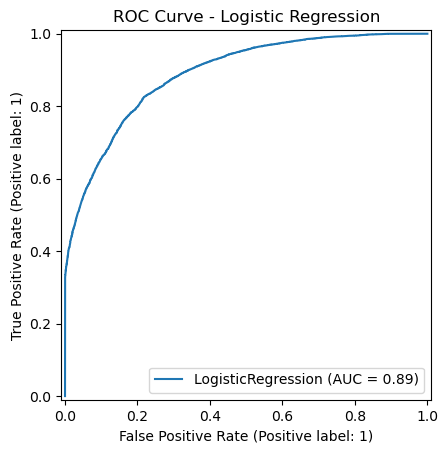

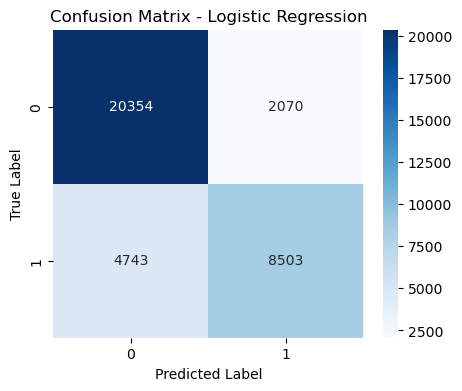

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

# Plot ROC curve
plt.figure(figsize=(6, 5))
RocCurveDisplay.from_estimator(logreg, X_test, y_test)
plt.title("ROC Curve - Logistic Regression")
plt.show()

# Plot confusion matrix as heatmap
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


## 2.3 Display Feature Coefficients of Logistic Regression

Top 15 most influential features (by absolute coefficient):
                         Feature  Coefficient
9    required_car_parking_spaces    -6.061760
14       deposit_type_Non Refund     5.002060
214         assigned_room_type_I    -4.580664
212         assigned_room_type_G    -3.136679
26                   country_ARE     2.870411
203         reserved_room_type_G     2.769166
215         assigned_room_type_K    -2.735852
211         assigned_room_type_F    -2.645078
201         reserved_room_type_E     2.294587
202         reserved_room_type_F     2.239869
210         assigned_room_type_E    -2.138708
90                   country_HKG     1.884118
170                  country_SRB    -1.740883
84                   country_GIB     1.718582
147                  country_NZL    -1.701144


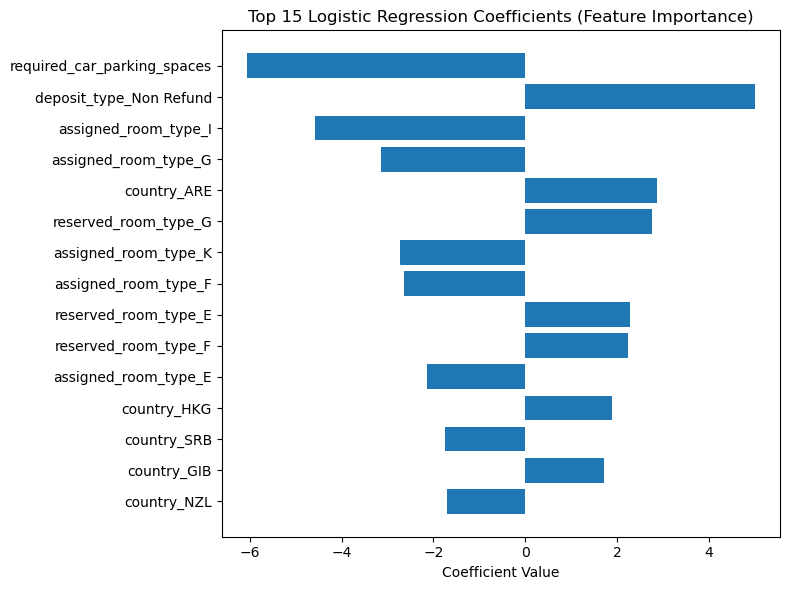

In [4]:
# Get feature names after one-hot encoding
feature_names = X_train.columns

# Get coefficients from the trained logistic regression model
coefficients = logreg.coef_[0]

# Combine feature names and coefficients into a DataFrame for easy viewing
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort by absolute value of coefficient (importance)
coef_df['abs_coef'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='abs_coef', ascending=False).drop('abs_coef', axis=1)

# Show the top 15 most influential features
print("Top 15 most influential features (by absolute coefficient):")
print(coef_df.head(15))

# Optionally, plot the top features
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.barh(coef_df['Feature'].head(15), coef_df['Coefficient'].head(15))
plt.xlabel('Coefficient Value')
plt.title('Top 15 Logistic Regression Coefficients (Feature Importance)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


# 3. Random Forest 

## 3.1 Modeling & Evaluation

In [5]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train the Random Forest model
rf = RandomForestClassifier(
    n_estimators=100,    # Number of trees
    max_depth=None,      # Allow trees to expand until all leaves are pure
    random_state=42,
    n_jobs=-1            # Use all CPU cores
)
rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]


## 3.2  Visualization for Random Forest

In [6]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
)

# Calculate evaluation metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_proba_rf)
cm_rf = confusion_matrix(y_test, y_pred_rf)

print("Random Forest Model Performance:")
print(f"Accuracy:  {accuracy_rf:.3f}")
print(f"Precision: {precision_rf:.3f}")
print(f"Recall:    {recall_rf:.3f}")
print(f"F1 Score:  {f1_rf:.3f}")
print(f"AUC:       {auc_rf:.3f}")
print("Confusion Matrix:")
print(cm_rf)


Random Forest Model Performance:
Accuracy:  0.857
Precision: 0.833
Recall:    0.767
F1 Score:  0.799
AUC:       0.928
Confusion Matrix:
[[20394  2030]
 [ 3086 10160]]


## 3.3 Display Feature Importances of Random Forest

Top 15 most important features in Random Forest:
                          Feature  Importance
0                       lead_time    0.283669
14        deposit_type_Non Refund    0.083997
156                   country_PRT    0.081566
8       total_of_special_requests    0.072858
2            stays_in_week_nights    0.069814
1         stays_in_weekend_nights    0.040309
4                 booking_changes    0.031236
21       market_segment_Online TA    0.027622
9     required_car_parking_spaces    0.024786
5                          adults    0.023359
19          market_segment_Groups    0.021229
20   market_segment_Offline TA/TO    0.018554
209          assigned_room_type_D    0.017261
12     distribution_channel_TA/TO    0.014280
219                       meal_HB    0.010861


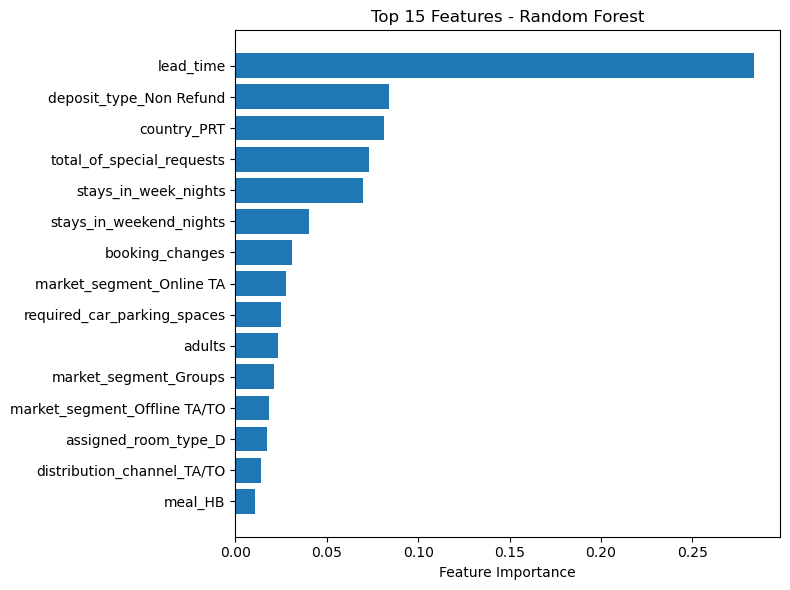

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importances
importances = rf.feature_importances_
feature_names = X_train.columns

# Combine into DataFrame for display
fi_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
fi_df = fi_df.sort_values(by='Importance', ascending=False)

# Show top 15 features
print("Top 15 most important features in Random Forest:")
print(fi_df.head(15))

# Bar plot of feature importances
plt.figure(figsize=(8, 6))
plt.barh(fi_df['Feature'].head(15), fi_df['Importance'].head(15))
plt.xlabel('Feature Importance')
plt.title('Top 15 Features - Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
